<a href="https://colab.research.google.com/github/Leander-csv/DC1/blob/Weighted-Loss-Function/Data_Challenge_1_Template_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction:
In this template, methods are provided to get you started on the task at hand (please see project description). Please implement your solution in the code cells marked with **TODO**. Most of the other code cells are hidden, feel free to explore and change these. These cells implement a basic pipeline for training your model but you may want to explore more complex procedures. **Make sure you run all cells before trying to implement your own solution!**

#Imports and definitions:

In [1]:
#@title
import numpy as np
import requests
import io
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import rotate
%matplotlib inline
from torch.utils.data import Dataset
import random
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm

class BatchSampler():
  """
  Implements an iterable which given a torch dataset and a batch_size
  will produce batches of data of that given size. The batches are
  returned as tuples in the form (images, labels).
  Can produce balanced batches, where each batch will have an equal 
  amount of samples from each class in the dataset. If your dataset is heavily
  imbalanced, this might mean throwing away a lot of samples from 
  over-represented classes!
  """

  def __init__(self, batch_size, dataset, balanced=False):
    self.batch_size = batch_size
    self.dataset = dataset
    self.balanced = balanced
    if self.balanced:
      # Counting the ocurrence of the class labels:
      unique, counts = np.unique(self.dataset.targets, return_counts=True) 
      indexes = []
      # Sampling an equal amount from each class:
      for i in range(len(unique)):
        indexes.append(np.random.choice(np.where(self.dataset.targets == i)[0], size=counts.min(), replace=False))
      # Setting the indexes we will sample from later:
      self.indexes = np.concatenate(indexes)
    else:
      # Setting the indexes we will sample from later (all indexes):
      self.indexes = [i for i in range(len(dataset))]


  def __len__(self):
    return (len(self.indexes) // self.batch_size) + 1
  
  def shuffle(self):
    # We do not need to shuffle if we use the balanced sampling method.
    # Shuffling is already done when making the balanced samples.
    if not self.balanced:
      random.shuffle(self.indexes)
    
  def __iter__(self):
    remaining = False
    self.shuffle()
    # Go over the datset in steps of 'self.batch_size':
    for i in range(0, len(self.indexes), self.batch_size):
        imgs, labels = [], []
        # If our current batch is larger than the remaining data, we quit:
        if i + self.batch_size > len(self.indexes):
          remaining = True
          break
        # If not, we yield a complete batch:
        else:
          # Getting a list of samples from the dataset, given the indexes we defined:
          X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, i + self.batch_size)]
          Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, i + self.batch_size)]
          # Stacking all the samples and returning the target labels as a tensor:
          yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()
    # If there is still data left that was not a full batch:
    if remaining:
      # Return the last batch (smaller than batch_size):
      X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, len(self.indexes))]
      Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, len(self.indexes))]
      yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()

class ImageDataset(Dataset):
  """
  Creates a DataSet from numpy arrays while keeping the data 
  in the more efficient numpy arrays for as long as possible and only
  converting to torchtensors when needed (torch tensors are the objects used
  to pass the data through the neural network and apply weights).
  """
  
  def __init__(self, x, y, transform=None, target_transform=None):
    self.targets = y
    self.imgs = x
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    image = torch.from_numpy(self.imgs[idx] / 255).float()
    label = self.targets[idx]
    return image, label

def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 


class_labels = {0: 'Atelectasis',
                1: 'Effusion',
                2: 'Infiltration',
                3: 'No Finding',
                4: 'Nodule',
                5: 'Pneumothorax'}

# Downloading the data:
The following cells will download the pre-processed X-ray images with their accompanying labels.

The download (400 MB) may take a while.

In [2]:
#@title
# Downloading the labels of each image:
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/i6MvQ8nqoiQ9Tci/download')
test_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/wLXiOjVAW4AWlXY/download')

In [3]:
#@title
# Downloading the images:
train_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4rwSf9SYO1ydGtK/download')
test_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/dvY2LpvFo6dHef0/download')

In [7]:
from sklearn.utils import class_weight


In [10]:
train_y = torch.tensor(train_y)

In [12]:
class_weights= class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_y), y = train_y.numpy())
class_weights= torch.tensor(class_weights,dtype=torch.float)
 
print(class_weights) #([1.0000, 1.0000, 4.0000, 1.0000, 0.5714])

tensor([1.1134, 1.2109, 0.9470, 0.4599, 1.7188, 2.1558])


# Plotting the data distribution:

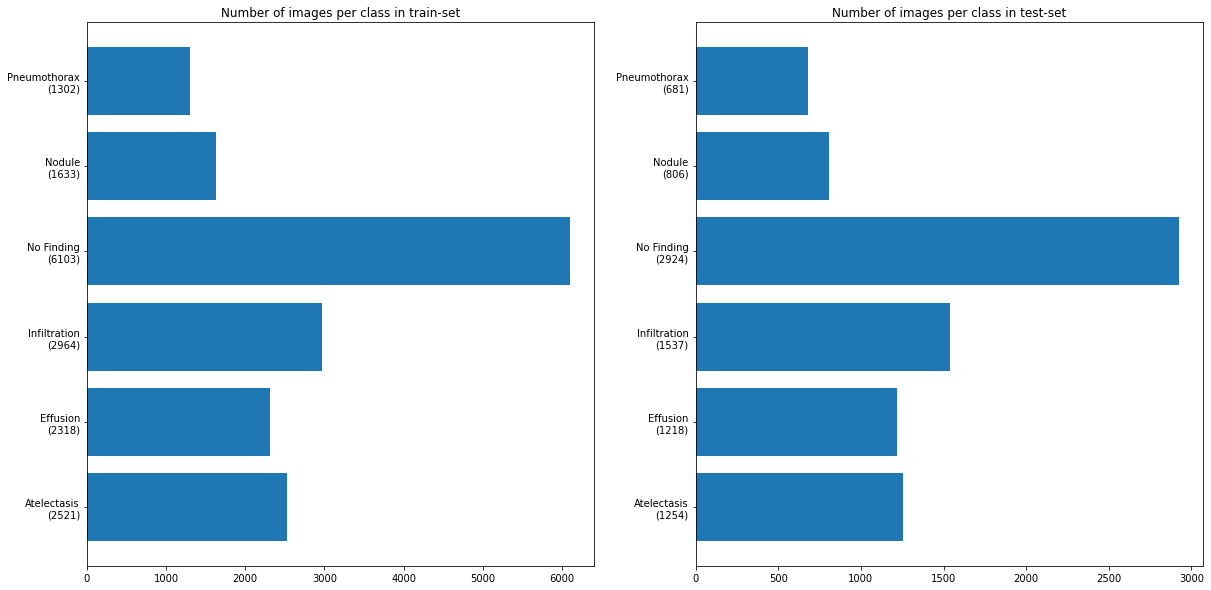

In [ ]:
#@title
# Plotting the label distribution in train/test set:
fig, ax = plt.subplots(ncols=2, figsize=[20,10])

unique, counts = np.unique(train_y, return_counts=True) 
ax[0].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[0].set_title('Number of images per class in train-set')

unique, counts = np.unique(test_y, return_counts=True) 
ax[1].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[1].set_title('Number of images per class in test-set');

#Plotting some samples:

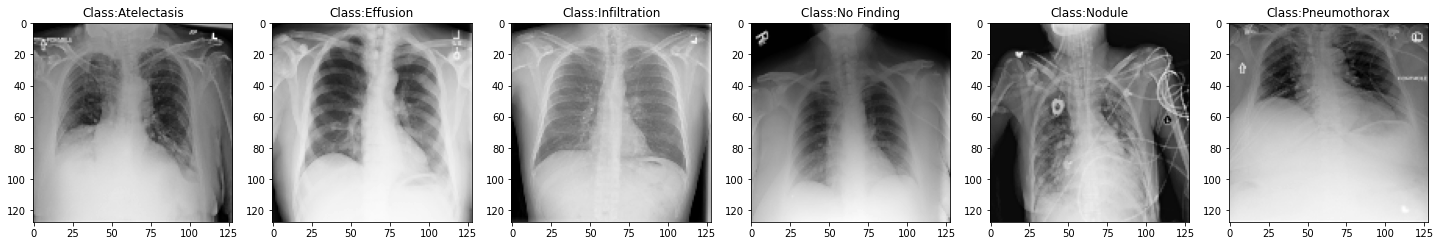

In [ ]:
#@title
# Plotting some images
unique_labels = set(class_labels.keys())
fig, ax = plt.subplots(ncols=len(unique_labels), figsize=[25,5])

for k, label in enumerate(unique_labels):
  ind = list(train_y).index(label)
  ax[k].imshow(train_x[ind].reshape(128,128), cmap='gray')
  ax[k].set_title(f'Class:{class_labels[train_y[ind]]}')

# Building torch datasets:

In [13]:
#@title
train_dataset = ImageDataset(train_x, train_y)
test_dataset = ImageDataset(test_x, test_y)

# Defining our model as a neural network:
**TODO** define your own model here, follow the structure as presented in the Pytorch tutorial (or see below as an example).

In [14]:
class Net(nn.Module):   
    def __init__(self, n_classes):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 64, kernel_size=4, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4),
            torch.nn.Dropout(p=0.5, inplace=True),
            # Defining another 2D convolution layer
            nn.Conv2d(64, 32, kernel_size=4, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            torch.nn.Dropout(p=0.25, inplace=True),
            # Defining another 2D convolution layer
            nn.Conv2d(32, 16, kernel_size=4, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(p=0.125, inplace=True),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(144, 256),
            nn.Linear(256, n_classes)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        # After our convolutional layers which are 2D, we need to flatten our
        # input to be 1 dimensional, as the linear layers require this.
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# Make sure your model instance is assigned to a variable 'model':
model = Net(n_classes = 6)

# Defining our loss and optimizer functions:
**TODO** Please define your own optimizer and loss function.

In [29]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.1)
loss_function = nn.CrossEntropyLoss(weight = class_weights, reduction = 'mean')
loss_function.to(device)

CrossEntropyLoss()

#Moving model to CUDA, verifying model structure and printing a summary:

In [23]:
# IMPORTANT! Set this to True to see actual errors regarding 
# the structure of your model (CUDA hides them)!
# Also make sure you set this to False again for actual model training
# as training your model with GPU-acceleration (CUDA) is much faster.
DEBUG = False

In [24]:
#@title
# Moving our model to the right device (CUDA will speed training up significantly!)
if torch.cuda.is_available() and not DEBUG:
  device = 'cuda'
  model.to(device)
  # Creating a summary of our model and its layers:
  summary(model, (1, 128, 128), device=device)
else:
  device='cpu'
  # Creating a summary of our model and its layers:
  summary(model, (1, 128, 128), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           1,088
       BatchNorm2d-2         [-1, 64, 125, 125]             128
              ReLU-3         [-1, 64, 125, 125]               0
         MaxPool2d-4           [-1, 64, 31, 31]               0
           Dropout-5           [-1, 64, 31, 31]               0
            Conv2d-6           [-1, 32, 28, 28]          32,800
       BatchNorm2d-7           [-1, 32, 28, 28]              64
              ReLU-8           [-1, 32, 28, 28]               0
         MaxPool2d-9             [-1, 32, 9, 9]               0
          Dropout-10             [-1, 32, 9, 9]               0
           Conv2d-11             [-1, 16, 6, 6]           8,208
      BatchNorm2d-12             [-1, 16, 6, 6]              32
             ReLU-13             [-1, 16, 6, 6]               0
        MaxPool2d-14             [-1, 1

#Defining our training/testing methods:

In [25]:
#@title
def train_model(model, train_sampler, optimizer, loss_function):
  # Lets keep track of all the losses:
  losses = []
  # Put the model in train mode:
  model.train()
  # Feed all the batches one by one:
  for batch in tqdm(train_sampler):
    # Get a batch:
    x, y = batch
    # Making sure our samples are stored on the same device as our model:
    x, y = x.to(device), y.to(device)
    # Get predictions:
    predictions = model.forward(x)
    loss = loss_function(predictions, y)
    losses.append(loss)
    # We first need to make sure we reset our optimizer at the start.
    # We want to learn from each batch seperately, 
    # not from the entire dataset at once.
    optimizer.zero_grad()
    # We now backpropagate our loss through our model:
    loss.backward()
    # We then make the optimizer take a step in the right direction.
    optimizer.step()
  return losses

def test_model(model, test_sampler, loss_function):
  # Setting the model to evaluation mode:
  model.eval()
  losses = []
  # We need to make sure we do not update our model based on the test data:
  with torch.no_grad():
    for (x, y) in tqdm(test_sampler):
      # Making sure our samples are stored on the same device as our model:
      x = x.to(device)
      y = y.to(device)
      prediction = model.forward(x)
      loss = loss_function(prediction, y)
      losses.append(loss)
  return losses

#Training our model:

In [26]:
n_epochs = 10
batch_size = 25

100%|██████████| 674/674 [00:25<00:00, 26.23it/s]



Epoch 1 training done, loss on train set: 1.7885931730270386



100%|██████████| 85/85 [00:04<00:00, 18.68it/s]



Epoch 1 testing done, loss on test set: 1.783439040184021



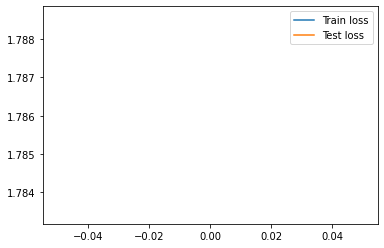

100%|██████████| 674/674 [00:25<00:00, 26.72it/s]



Epoch 2 training done, loss on train set: 1.7551862001419067



100%|██████████| 85/85 [00:04<00:00, 19.02it/s]



Epoch 2 testing done, loss on test set: 1.7700220346450806



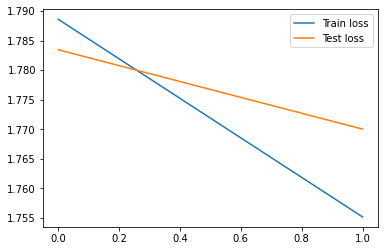

100%|██████████| 674/674 [00:25<00:00, 26.46it/s]



Epoch 3 training done, loss on train set: 1.7371432781219482



100%|██████████| 85/85 [00:04<00:00, 18.35it/s]



Epoch 3 testing done, loss on test set: 1.7560555934906006



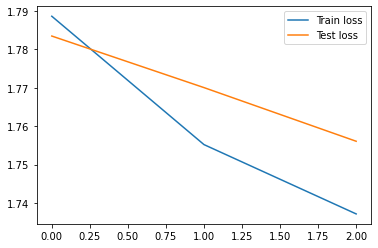

100%|██████████| 674/674 [00:25<00:00, 26.18it/s]



Epoch 4 training done, loss on train set: 1.727982997894287



100%|██████████| 85/85 [00:04<00:00, 17.67it/s]



Epoch 4 testing done, loss on test set: 1.742768406867981



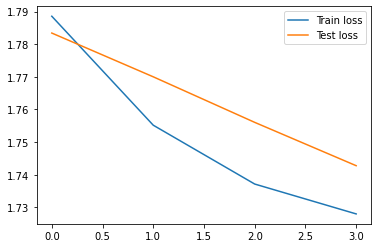

100%|██████████| 674/674 [00:25<00:00, 26.24it/s]



Epoch 5 training done, loss on train set: 1.716861367225647



100%|██████████| 85/85 [00:04<00:00, 18.95it/s]



Epoch 5 testing done, loss on test set: 1.7330735921859741



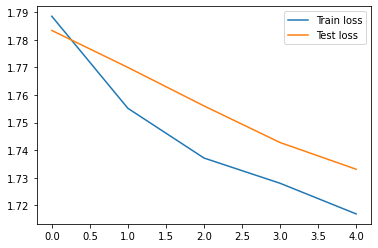

100%|██████████| 674/674 [00:25<00:00, 26.48it/s]



Epoch 6 training done, loss on train set: 1.7140910625457764



100%|██████████| 85/85 [00:04<00:00, 18.79it/s]



Epoch 6 testing done, loss on test set: 1.7260457277297974



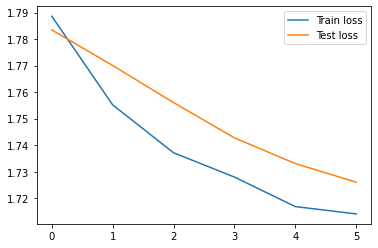

100%|██████████| 674/674 [00:25<00:00, 26.43it/s]



Epoch 7 training done, loss on train set: 1.7097123861312866



100%|██████████| 85/85 [00:04<00:00, 18.96it/s]



Epoch 7 testing done, loss on test set: 1.7189263105392456



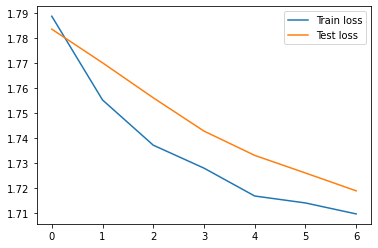

100%|██████████| 674/674 [00:25<00:00, 26.48it/s]



Epoch 8 training done, loss on train set: 1.7042741775512695



100%|██████████| 85/85 [00:04<00:00, 18.94it/s]



Epoch 8 testing done, loss on test set: 1.7163169384002686



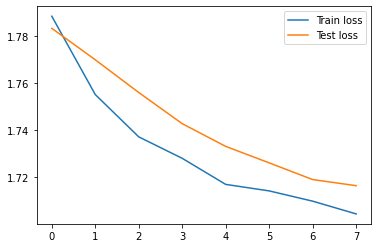

100%|██████████| 674/674 [00:25<00:00, 26.49it/s]



Epoch 9 training done, loss on train set: 1.6994065046310425



100%|██████████| 85/85 [00:04<00:00, 18.97it/s]



Epoch 9 testing done, loss on test set: 1.7054243087768555



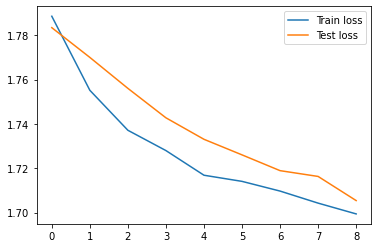

100%|██████████| 674/674 [00:25<00:00, 26.46it/s]



Epoch 10 training done, loss on train set: 1.6960405111312866



100%|██████████| 85/85 [00:04<00:00, 18.89it/s]



Epoch 10 testing done, loss on test set: 1.7014816999435425



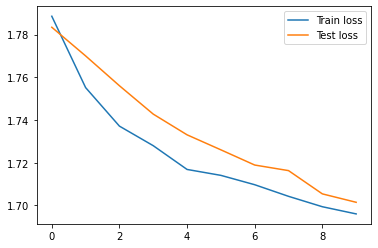

In [30]:
#@title
# Lets now train and test our model for multiple epochs:
train_sampler = BatchSampler(batch_size=batch_size, dataset=train_dataset, balanced=False)
test_sampler = BatchSampler(batch_size=100, dataset=test_dataset, balanced=False)

mean_losses_train = []
mean_losses_test = []
accuracies = []
for e in range(n_epochs):
  # Training:
  losses = train_model(model, train_sampler, optimizer, loss_function)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses_train.append(mean_loss)
  print(f'\nEpoch {e + 1} training done, loss on train set: {mean_loss}\n')

  # Testing:
  losses = test_model(model, test_sampler, loss_function)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses_test.append(mean_loss)
  print(f'\nEpoch {e + 1} testing done, loss on test set: {mean_loss}\n')
  # Plotting the historic loss:
  fig, ax = plt.subplots()
  ax.plot(mean_losses_train, label='Train loss')
  ax.plot(mean_losses_test, label='Test loss')
  ax.legend()
  plt.show()

#Evaluation our model:
**TODO** write your own methods to evaluate the model. For example, calculate the accuracy of the model on the test-set:

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [32]:
model.eval()
# We need to make sure we do not update our model based on the test data:
with torch.no_grad():
  correct = 0
  count = 0
  for (x, y) in tqdm(test_sampler):
    # Making sure our samples are stored on the same device as our model:
    x = x.to(device)
    y = y.to(device)
    prediction = model.forward(x).argmax(axis=1)
    correct += sum(prediction == y)
    count += len(y)
accuracy = (correct/count).detach().cpu().numpy()
print(f'\nAccuracy of model on test set: {accuracy}')

100%|██████████| 85/85 [00:04<00:00, 18.37it/s]


Accuracy of model on test set: 0.24976247549057007


In [33]:
for batch in tqdm(train_sampler):
    # Get a batch:
    images, labels = batch
    # Making sure our samples are stored on the same device as our model:
    images, labels= images.to(device), labels.to(device)
    # Get predictions:
    predictions = model.forward(images)

100%|██████████| 674/674 [00:10<00:00, 62.35it/s]


In [34]:
stacked = torch.stack(
    (
       torch.tensor(labels)
     , predictions.argmax(dim=1)   
    )
    ,dim=1
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
cm = confusion_matrix(labels.cpu(), predictions.cpu().argmax(dim=1))
cm

array([[1, 1, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1],
       [1, 1, 3, 1, 1, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [36]:
cmt = torch.zeros(6,6, dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]])

In [37]:
for p in stacked:
    true_label, pred_label = p.tolist()
    cmt[true_label,pred_label] = cmt[true_label,pred_label] + 1

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

100%|██████████| 674/674 [00:14<00:00, 46.04it/s]


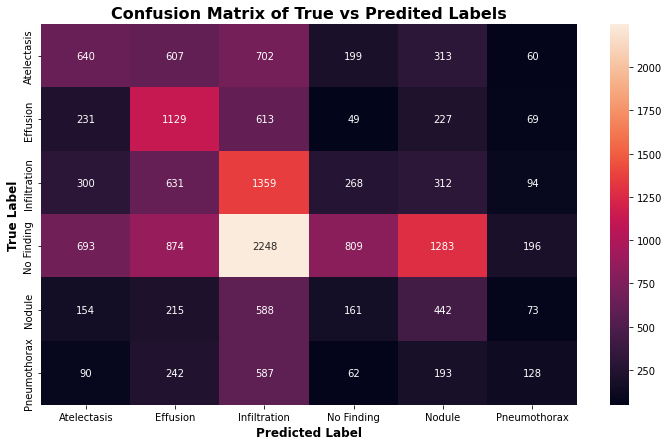

In [39]:
model.eval()
# We need to make sure we do not update our model based on the test data:
with torch.no_grad():

  #create lists that store true and pred labels
  y_pred = []
  y_true = []

  # iterate over train data batch
  for inputs, labels in tqdm(train_sampler):
          inputs, labels = inputs.to(device), labels.to(device)
          output = model(inputs) 

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # constant for classes
  classes = [items[1] for items in class_labels.items()]

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))

  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.ylabel('True Label', weight='bold', size=12)
  plt.xlabel('Predicted Label', weight='bold',size=12)
  plt.title('Confusion Matrix of True vs Predited Labels', weight='bold', size=16)

This accuracy isn't great. Your task is to find a better model that performs better at the classification task. Other methods of evaluation might tell you more why a particular model is not performing well (accuracy is a quite limited aggregated performance metric). 

#Saving our model:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
torch.save(model.state_dict(), '/content/gdrive/My Drive/weights_model.txt')